# Overfitting and Regularization

## Imports

In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [87]:
set_config(display='diagram')

## Settings

In [88]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(1, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [89]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

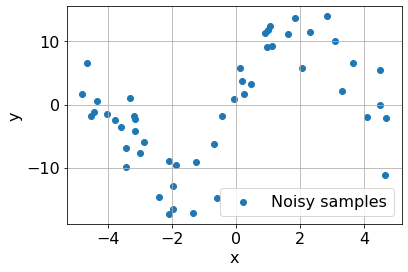

In [90]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

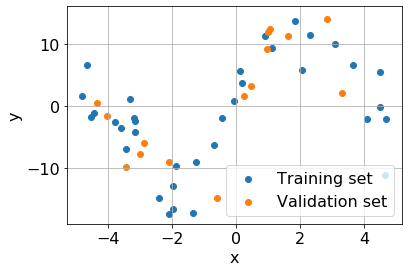

In [91]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [92]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [93]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [94]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

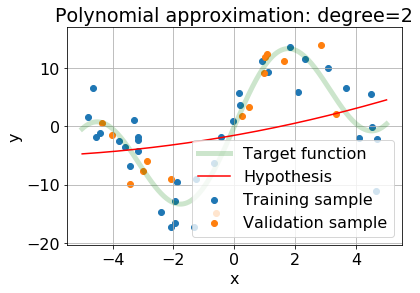

In [95]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

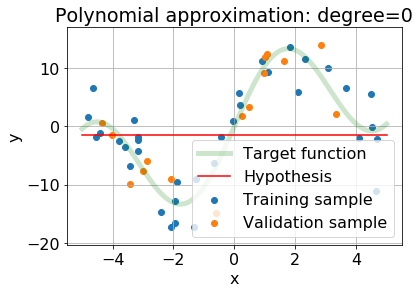

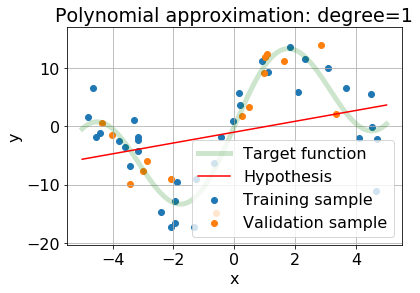

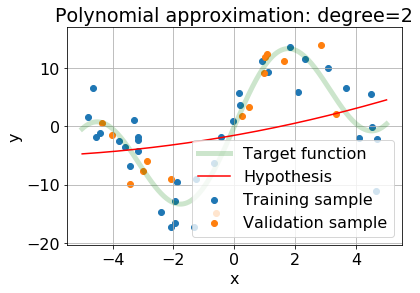

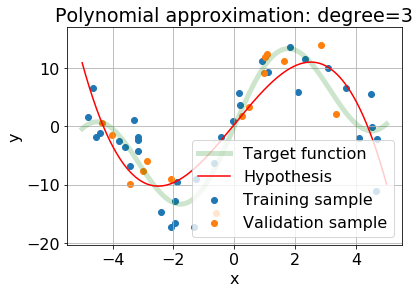

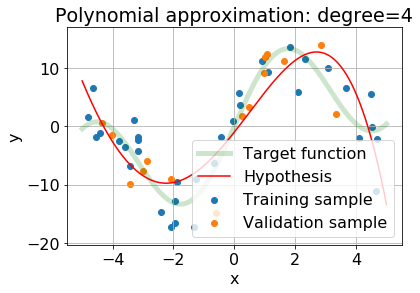

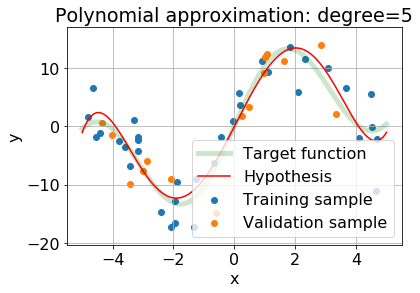

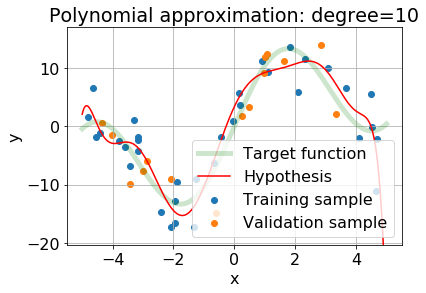

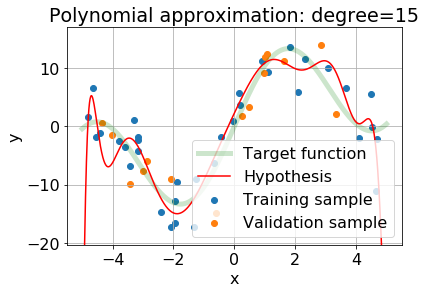

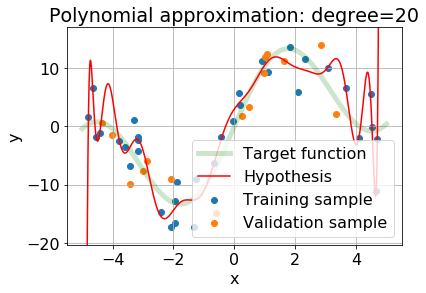

In [96]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

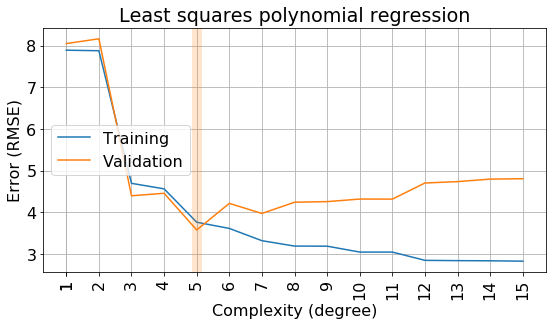

In [97]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [98]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

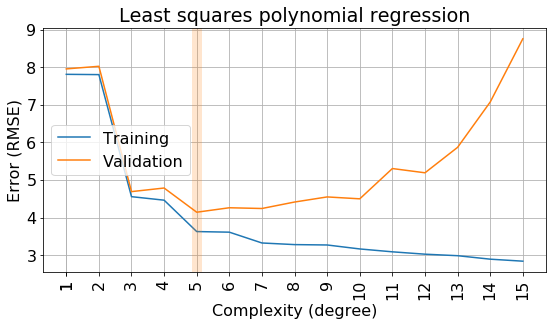

In [99]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [100]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

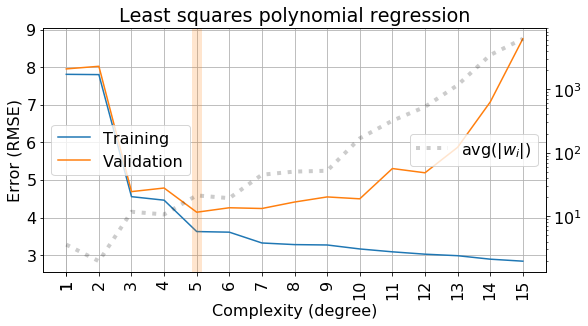

In [101]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

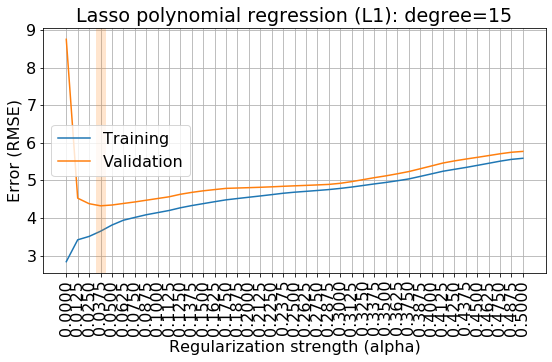

In [102]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

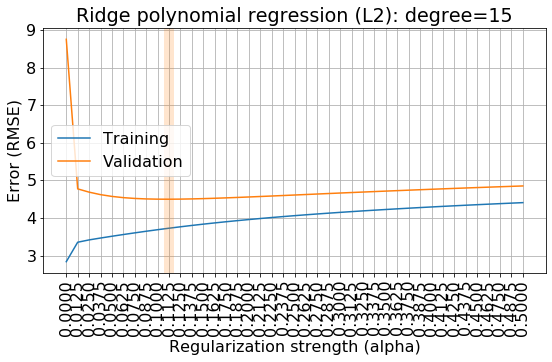

In [103]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [104]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

Нам (в частности мне) необходимо в рамках данной домашки сделать ... я не знаю что, если честно... есть общее понимание, что в первом задании необходимо определить наиболее "оптимальный" degrees (что это?). Сижу пол дня, читаю комментарии, которые пипец не отличаются культурой формализации мыслей, слэнг не понятен обывателю, все эти "фичи", "колумнтрансформы" и прочие русскоязычные англицизмы немного выводят из себя... можно по человечески грамотным языком объяснить, не выпендриваясь? Короче

1. Посмотрим что у нас там с корреляциями (незнаю зачем, просто потому что могу это):

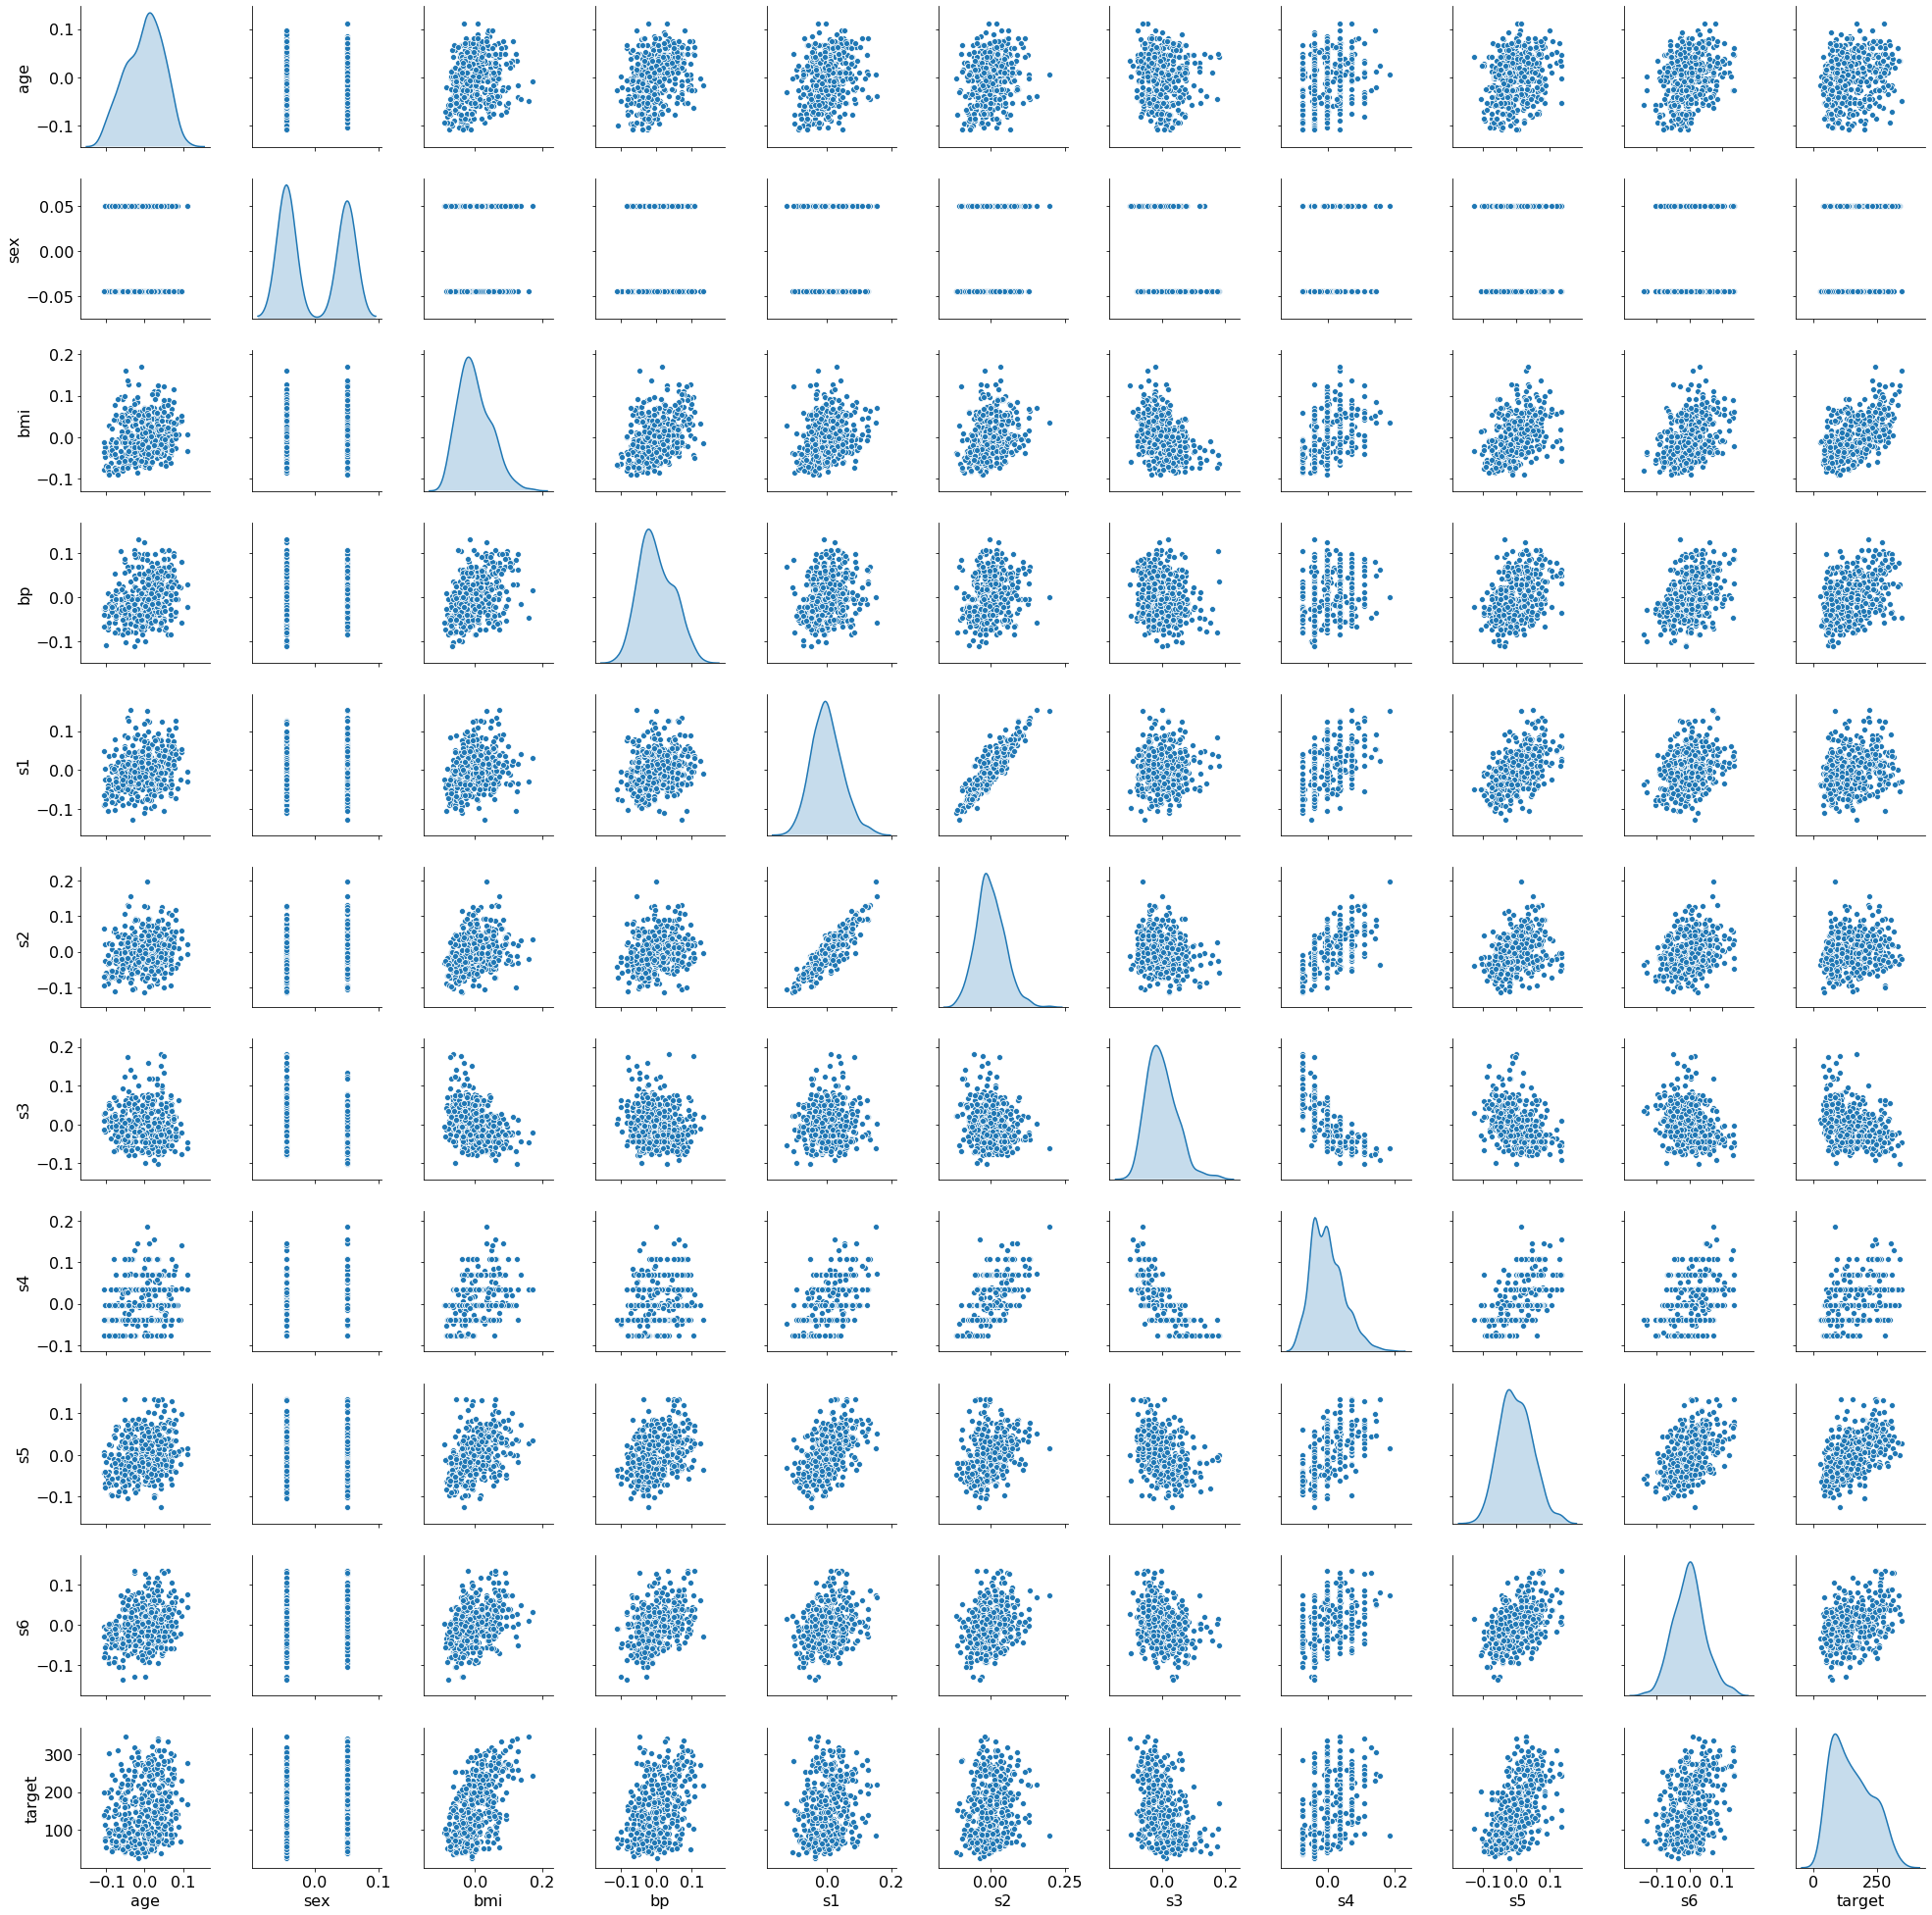

In [105]:
sns.pairplot(pd.concat([X_diabetes, y_diabetes], axis=1), diag_kind = 'kde');

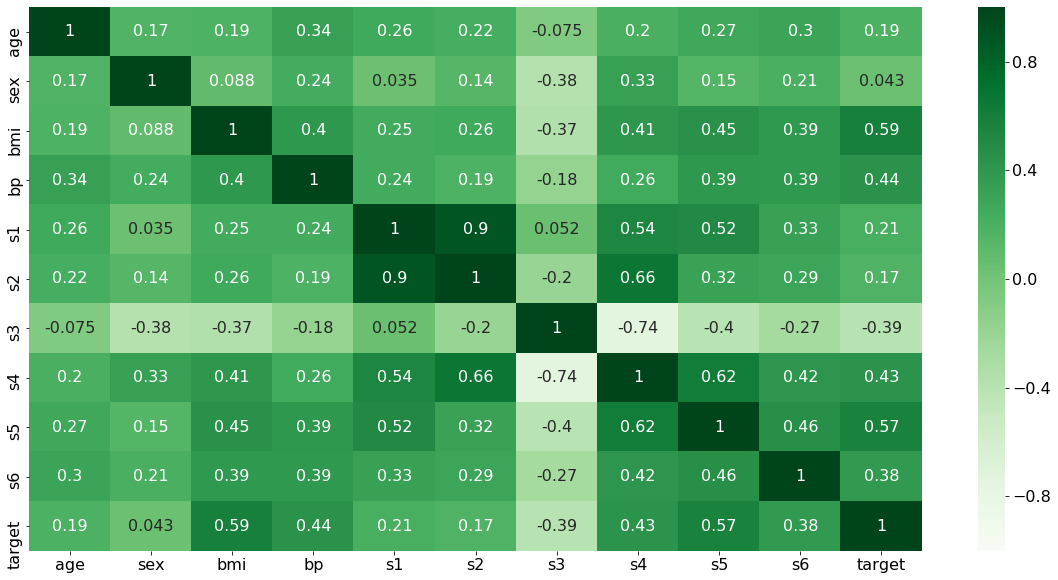

In [107]:
import warnings                       # используем блокировщика "спама" (warninga), 
warnings.filterwarnings('ignore')
plt.figure(figsize=(20 , 10))
plt.rcParams['font.size'] = '16'
sns.heatmap(pd.concat([X_diabetes, y_diabetes], axis=1).corr(), cmap = "Greens", vmin = -1.0, vmax = 1.0, center = 0.0, annot = True);
warnings.filterwarnings("default")

2. Разделим наш набор данных на тренировочный (train) и проверочный (valid) наборы данных:

In [108]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)
#X_train

3. Теперь требуется вроде как выполнить "полиномизацию" набора данных X_train (тот самый degrees - 
и есть степень полиномизации, в которую мы должны возводить значения наших признаков)
Т.к. вычислительных мощностей для этой операции у меня не достаточно (и на компе в Юпитере и в Колабе),
решаем полимизировать по предложенному в задании алгоритму:
    - делим X_train по колонкам (3:7 в моем случае)
    - первую часть "полиномизируем"
    - соединяем полученные колонки с нетронутым остатком X_train
Для этого запилим функцию, которыя полиномизирует самые коррелируемые признаки ('bmi', 'bp', 's4') и возвращает датасет всех данных + новые колонки ("рожденные" полиномизацией):

In [109]:
def separate_pol_concat(degree, X):
    pol = ['bmi', 'bp', 's4']
    without_pol = ['age', 'sex', 's1', 's2', 's3', 's5', 's6']
    df_pol = pd.DataFrame(PolynomialFeatures(degree, include_bias=False).fit_transform(X[pol]))
    df_pol.reset_index(drop=True, inplace=True)
    df_without_pol = X[without_pol]
    df_without_pol.reset_index(drop=True, inplace=True)
    result = pd.concat([df_pol, df_without_pol], axis=1)
    return result

P.S. Да, печально, что только три признака, но по другому с таким компом видимо никак:(

4. Проверим работу функции:

In [110]:
print(X_train.shape)
print(X_valid.shape)
print(separate_pol_concat(5, X_train).shape)
print(separate_pol_concat(5, X_valid).shape)

(309, 10)
(133, 10)
(309, 62)
(133, 62)


5. Попробуем сделать вид, что поняли задание и слижем две функции из теоретической информации сверху, несколько изменив ее (в качестве X_train и X_valid используем нашу функцию).


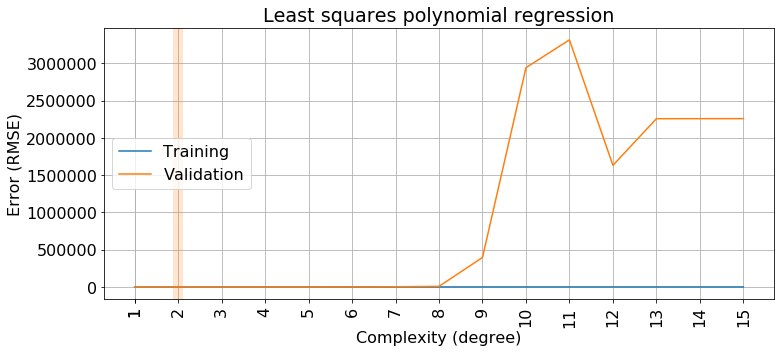

In [111]:
import warnings                       # используем блокировщика "спама" (warninga), 
warnings.filterwarnings('ignore')     # любезно предоставленного в чатике discorda

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(12, 5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = LinearRegression(fit_intercept=True).fit(separate_pol_concat(degree, X_train), y_train)
    rmse_train.append(rmse(reg.predict(separate_pol_concat(degree, X_train)), y_train))
    rmse_valid.append(rmse(reg.predict(separate_pol_concat(degree, X_valid)), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')
warnings.filterwarnings("default")

6. Получили какой-то даже вроде не странный график, намекающий нам, что степень "полиномизации" 2 - 
вроде как не плохой для нас вариант. Почему именно 2 я хз, вначале, когда моя функция полиномизировала только один признак оптимальная степень равнялась 6. Надеюсь на сегодняшнем стриме объяснят эту ересь. Простите.

7. Подтверждаем (как в теории):

In [112]:
DEGREES[np.argmin(rmse_valid)]

2

8. Попробуем проделать то-же самое с кросс-валидацией:

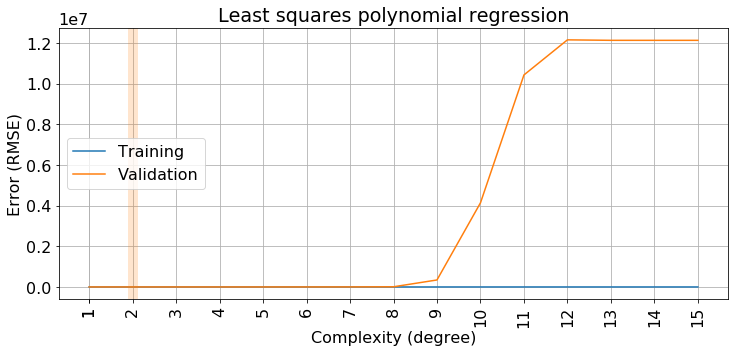

In [113]:
import warnings                    # снова вставляем блокировщика "спама"
warnings.filterwarnings('ignore')

rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(LinearRegression(fit_intercept=True), 
                             separate_pol_concat(degree, X_diabetes), y_diabetes, cv=3,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')
warnings.filterwarnings("default")

9. Есть какие-то отличия... Однако оптимальная степень полиномизации такая же (2) как при "обычном" разбиении данных.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

Итак, видимо нам (мне), в рамках данного задания необходимо показать какая "замечательная" регуляризация.
Для этого, покажем, какие "плохие" коэффициенты у нас по дефолту (термин, которым я нахватался в чатике,
раньше думал что это значит неспособность платить по кредитным обязательствам):

In [114]:
import warnings 
warnings.filterwarnings('ignore')
print('degree = 1')
D_1 = pd.DataFrame(LinearRegression(fit_intercept=True).fit(separate_pol_concat(1, X_train), y_train).coef_.T)
print(D_1)
print()
print('degree = 2')
D_2 = pd.DataFrame(LinearRegression(fit_intercept=True).fit(separate_pol_concat(2, X_train), y_train).coef_.T)
print(D_2)
print()
print('degree = 5')
D_5 = pd.DataFrame(LinearRegression(fit_intercept=True).fit(separate_pol_concat(5, X_train), y_train).coef_.T)
print(D_5)
print()
print('degree = 10')
D_10 = pd.DataFrame(LinearRegression(fit_intercept=True).fit(separate_pol_concat(10, X_train), y_train).coef_.T)
print(D_10)
print()
warnings.filterwarnings("default")

degree = 1
            0
0  546.297373
1  388.400773
2  288.029325
3   29.250346
4 -261.707681
5 -901.953387
6  506.761149
7  121.148459
8  659.271338
9   41.375369

degree = 2
              0
0    466.124677
1    363.686931
2    164.474715
3   1609.688501
4   2265.071977
5    410.338495
6   -142.643724
7    124.855112
8    527.378195
9     77.782160
10  -266.444688
11  -917.579447
12   613.642514
13    60.549409
14   696.827415
15    44.467753

degree = 5
               0
0   3.557241e+02
1   1.239569e+02
2   4.020307e+02
3  -3.567337e+03
4   8.972647e+03
5   2.964066e+03
6  -8.956954e+03
7   9.632915e+02
8  -5.939935e+02
9   8.275973e+04
10 -1.361056e+05
11 -3.020013e+05
12  2.960775e+05
13  1.663447e+05
14  1.518740e+05
15 -9.396367e+03
16 -3.346771e+05
17  1.894425e+05
18 -3.813283e+04
19 -7.830871e+05
20  9.851970e+05
21  1.099437e+05
22  3.004780e+06
23 -4.121492e+06
24  2.023727e+06
25 -2.796087e+06
26  1.124938e+06
27  2.697790e+06
28 -2.041177e+06
29  1.145673e+06
..          

О ужас, с увеличением степени полиномизации, коэффициенты улетают в небо (пародирую создателя вышеизложенной теории). Посмотрим L2-норму:

In [115]:
def l2_norm(arr):
    return float(np.sqrt((np.sum(np.square(arr)))))
print('degree = 1')
print(l2_norm(D_1))
print()
print('degree = 2')
print(l2_norm(D_2))
print()
print('degree = 5')
print(l2_norm(D_5))
print()
print('degree = 10')
print(l2_norm(D_1))
print()

degree = 1
1457.0373045865367

degree = 2
3219.8518603046427

degree = 5
197664413.7504265

degree = 10
1457.0373045865367



Нужно срочно что-то придумать... О! - используем "Лассо" и "Хребет" (пипец дико звучит). На самом
деле на бумажке я вроде приблизительно понял как это работает. Посмотрим еще на наши "плохие" коэффициенты:

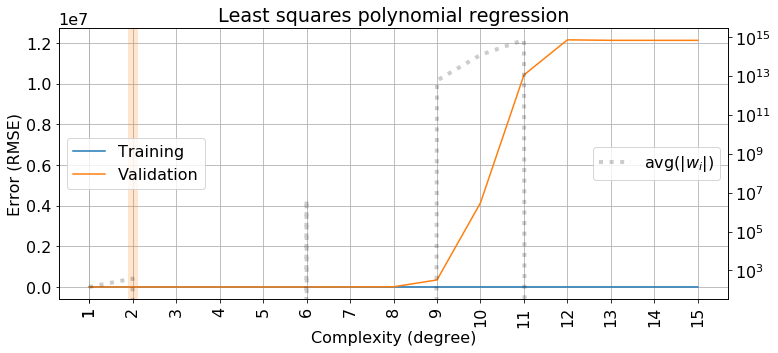

In [116]:
import warnings
warnings.filterwarnings('ignore')

rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(LinearRegression(fit_intercept=True),
                             separate_pol_concat(degree, X_diabetes), y_diabetes, cv=3,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(LinearRegression(fit_intercept=True).fit(separate_pol_concat(degree, X_train), y_train).coef_)
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')
warnings.filterwarnings("default")

Интуитивно кажется, что я где-то накосячил принципиально. Но буду надеяться, все еще расчитываю на "достойное" объяснение на сегодняшнем стриме. И средние значения коэффициентов какие-то стремные, незнаю - незнаю...

#### L1

1. Копируем и правим блок кода из лекции:

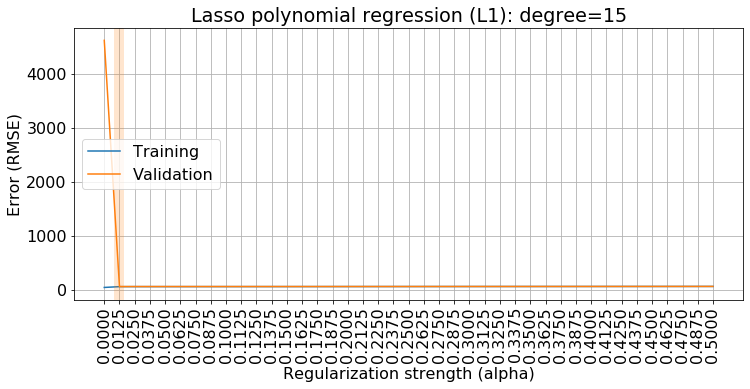

In [117]:
import warnings         # и опять используем блокировщика "спама" (последний раз пишу об этом)
warnings.filterwarnings('ignore')

rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(Lasso(alpha=alpha, random_state=SEED, max_iter=50000), 
                             separate_pol_concat(15, X_diabetes), y_diabetes, cv=3,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')
warnings.filterwarnings("default")

2. Довольно убогий график ... ну типа видим, что с увеличением Альфы, ошибка уменьшается и становится почти нулевой.
Оптимальная Альфа = 0,0125. Единственное не понятно, правильно ли я понял задание, ведь надо было посмотреть коэффициенты, а не ошибку...

3. Глянем коэффициенты:

In [118]:
import warnings 
warnings.filterwarnings('ignore')

print('degree = 1')
L_1_D_1 = pd.DataFrame(Lasso(alpha=0.0125, random_state=SEED, max_iter=50000).fit(separate_pol_concat(1, X_train), y_train).coef_)
print(L_1_D_1)
print()
print('degree = 2')
L_1_D_2 = pd.DataFrame(Lasso(alpha=0.0125, random_state=SEED, max_iter=50000).fit(separate_pol_concat(2, X_train), y_train).coef_)
print(L_1_D_2)
print()
print('degree = 5')
L_1_D_5 = pd.DataFrame(Lasso(alpha=0.0125, random_state=SEED, max_iter=50000).fit(separate_pol_concat(5, X_train), y_train).coef_)
print(L_1_D_5)
print()
print('degree = 10')
L_1_D_10 = pd.DataFrame(Lasso(alpha=0.0125, random_state=SEED, max_iter=50000).fit(separate_pol_concat(10, X_train), y_train).coef_)
print(L_1_D_10)
warnings.filterwarnings("default")

degree = 1
            0
0  558.679958
1  378.728878
2  216.599359
3   27.981205
4 -248.094210
5 -361.177103
6   82.682625
7 -105.299941
8  451.309412
9   44.616902

degree = 2
             0
0   530.540811
1   373.265099
2   206.152132
3   609.390234
4   452.764806
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9    40.729480
10 -248.487230
11 -358.752984
12   98.379219
13 -112.755935
14  455.400075
15   46.327551

degree = 5
             0
0   530.540811
1   373.265099
2   206.152132
3   609.390234
4   452.764806
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13   -0.000000
14   -0.000000
15    0.000000
16    0.000000
17   -0.000000
18   -0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23   -0.000000
24    0.000000
25    0.000000
26    0.000000
27   -0.000000
28    0.000000
29    0.000000
..         ...
32   -0.000000
33   -0.000000
34    0.000000
35   -0.000000
36    0.000000
3

Что-то много нулевых коэффициентов... сорри, Ай донт андерстенд.

Посмотрим L1-норму (надеюсь я ее не выдумал)

In [119]:
def l1_norm(arr):
    return float(np.sqrt((np.sum(abs(arr)))))
print('degree = 1')
print(l1_norm(L_1_D_1))
print()
print('degree = 2')
print(l1_norm(L_1_D_2))
print()
print('degree = 5')
print(l1_norm(L_1_D_5))
print()
print('degree = 10')
print(l1_norm(L_1_D_1))
print()

degree = 1
49.75107630828802

degree = 2
59.438586412371535

degree = 5
59.438586412371535

degree = 10
49.75107630828802



Ни о чем не говорит, увы:(

#### L2

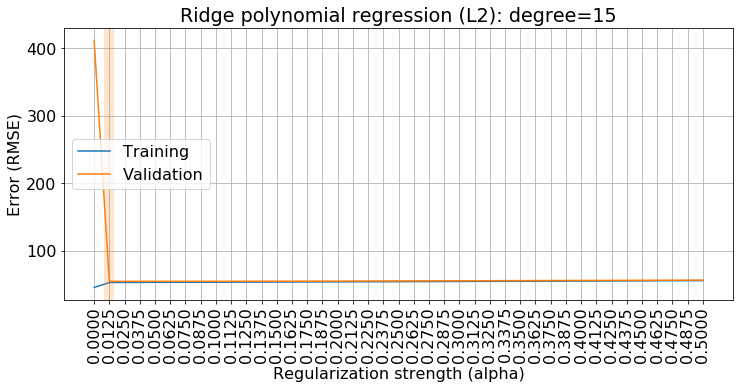

In [120]:
import warnings
warnings.filterwarnings('ignore')

rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(Ridge(alpha=alpha, random_state=SEED, max_iter=50000), 
                             separate_pol_concat(15, X_diabetes), y_diabetes, cv=3,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')
warnings.filterwarnings("default")

То же самое. Глянем коэффициенты:

In [121]:
import warnings 
warnings.filterwarnings('ignore')

print('degree = 1')
L_2_D_1 = pd.DataFrame(Ridge(alpha=0.0125, random_state=SEED, max_iter=50000).fit(separate_pol_concat(1, X_train), y_train).coef_.T)
print(L_2_D_1)
print()
print('degree = 2')
L_2_D_2 = pd.DataFrame(Ridge(alpha=0.0125, random_state=SEED, max_iter=50000).fit(separate_pol_concat(2, X_train), y_train).coef_.T)
print(L_2_D_2)
print()
print('degree = 5')
L_2_D_5 = pd.DataFrame(Ridge(alpha=0.0125, random_state=SEED, max_iter=50000).fit(separate_pol_concat(5, X_train), y_train).coef_.T)
print(L_2_D_5)
print()
print('degree = 10')
L_2_D_5 = pd.DataFrame(Ridge(alpha=0.0125, random_state=SEED, max_iter=50000).fit(separate_pol_concat(10, X_train), y_train).coef_.T)
print(L_2_D_5)
warnings.filterwarnings("default")

degree = 1
            0
0  550.209948
1  377.602495
2  208.139288
3   34.648948
4 -252.573843
5 -360.491782
6   90.132609
7 -118.145565
8  446.405447
9   51.693683

degree = 2
             0
0   532.490220
1   372.043356
2   187.925651
3   365.492870
4   333.017362
5   140.526489
6   129.303688
7    74.277737
8    66.881838
9    45.690501
10 -252.535462
11 -359.224494
12  106.424703
13 -129.944773
14  450.802499
15   51.481821

degree = 5
             0
0   532.174700
1   371.950120
2   188.099579
3   365.014788
4   332.959007
5   140.534215
6   129.250003
7    74.351938
8    67.237335
9    37.677879
10   10.073471
11    5.952954
12    7.771845
13  -10.646293
14   -4.380551
15   12.952875
16    2.280361
17   -3.487977
18  -16.236748
19    7.351319
20    1.718150
21    2.162579
22    1.793255
23   -0.322465
24    1.191255
25    1.779856
26    0.269615
27   -0.483838
28    0.051787
29    1.714811
..         ...
32   -0.287228
33   -4.121075
34    0.941035
35    0.012306
36    0.218405
3

Нулей что-то поубавилось...

Смотрим L2-норму:

In [122]:

print('degree = 1')
print(l2_norm(L_2_D_1))
print()
print('degree = 2')
print(l2_norm(L_2_D_2))
print()
print('degree = 5')
print(l2_norm(L_2_D_5))
print()
print('degree = 10')
print(l2_norm(L_2_D_1))
print()

degree = 1
952.689528139024

degree = 2
1084.993270796316

degree = 5
1085.7039728189704

degree = 10
952.689528139024



#### Summary

Нуууу, вывод такой - использовать регуляризацию надо обязательно, она хорошая, вон как ошибку уменьшает.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

ААААА - что надо сделать?!?! Мне кажется я исчерпал весь свой потенциал по L1 и L2 в предыдущем занятии,
может я 3-е уже там выполнил, а?) Ну серьезно...

#### L1

In [ ]:
## your code

#### L2

In [ ]:
## your code

#### Summary

In [ ]:
# your findings/conclusions

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [159]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


В общем времени час остался, заканчиваю болтать успею что успею, адьес

Смотрим данные

In [160]:
print(len(X_hw))
print(len(y_hw))

50
50


In [161]:
pd.DataFrame(X_hw).head()

,0,1,2
0,-0.012546,-384.945434,80.667093
1,0.045071,109.066539,182.952436
2,0.023199,-366.609036,-2.353457
3,0.009866,-259.410380,169.965849
4,-0.034398,-172.860944,66.049644


In [162]:
pd.DataFrame(y_hw).head()

,0
0,3.556569
1,2.478158
2,11.767762
3,-0.497741
4,-11.225224


Смотрим корреляции

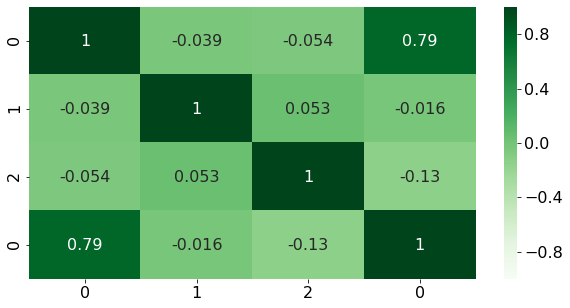

In [163]:
import warnings                       # используем блокировщика "спама" (warninga), 
warnings.filterwarnings('ignore')
plt.figure(figsize=(10 , 5))
plt.rcParams['font.size'] = '16'
sns.heatmap(pd.concat([pd.DataFrame(X_hw), pd.DataFrame(y_hw)], axis=1).corr(), cmap = "Greens", vmin = -1.0, vmax = 1.0, center = 0.0, annot = True);
warnings.filterwarnings("default")

Скалируем данные (вряят ли)

In [164]:
make_model(degree=15).fit(X_hw, y_hw)['sca']

StandardScaler()

In [165]:
pd.DataFrame(X_hw).head()

,0,1,2
0,-0.012546,-384.945434,80.667093
1,0.045071,109.066539,182.952436
2,0.023199,-366.609036,-2.353457
3,0.009866,-259.410380,169.965849
4,-0.034398,-172.860944,66.049644


In [167]:
pd.DataFrame(y_hw).head()

,0
0,3.556569
1,2.478158
2,11.767762
3,-0.497741
4,-11.225224


Сплитим данные

In [168]:
X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

Смотрим коэффициенты

In [169]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([ 5.33553525, -0.30773502, -1.33951562]),
 array([ 4.49598687, -2.91569382, -2.4530345 ,  0.78601066, -0.01881441,
         1.00875453,  0.63224087,  2.52474024,  0.9456366 ]),
 array([-11.29199184, -31.8290994 , -30.04549005,  29.37879531,
          1.16599832,  16.89601034,  25.03111178,   8.54015339,
         20.65586143,  16.05511648,  -6.17609386,  -5.50786558,
        -10.69322943, -23.24803272,  -7.42606103,   8.20312657,
         -6.001469  ,  25.44737178,  25.12532443, -15.77206385,
         20.22923938,  14.50016191, -13.24524307,  -8.75280586,
          4.03028512,  21.79902492,  22.50316336, -21.27103473,
         -9.4843661 , -27.47569429,  -8.09148047,   1.5774332 ,
          9.97185436,   0.26143731, -15.207144  ,  20.09033525,
        -18.07778656, -17.03710123,  -7.20954466,  -7.1992907 ,
        -20.5908208 ,  26.63142838,   3.22803051,   5.12539218,
        -12.93654687,   7.28073823,   3.79590523,  23.0973055 ,
         12.47704596,  26.93291089,   1.0906786 

Кросс-валидируем через созданную в лекции модель (наша функция уже не очень нужна т.к. всего три признака)

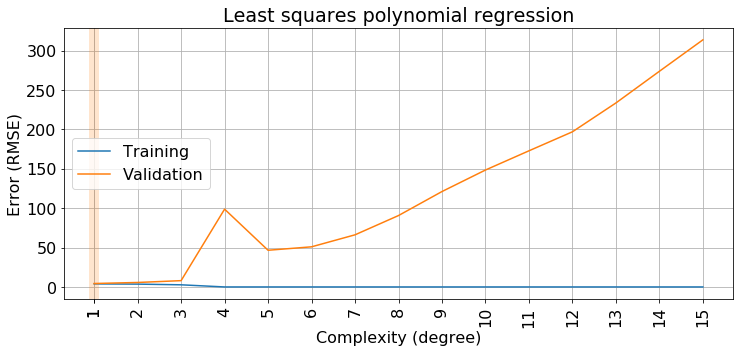

In [170]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X_hw, y_hw, cv=3,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

Смотрим коэффициенты:

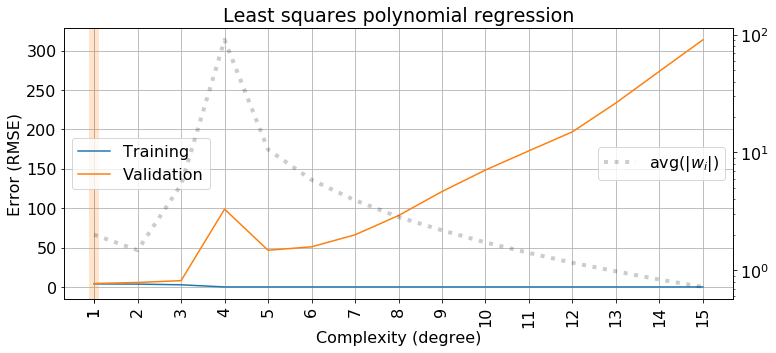

In [171]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X_hw, y_hw, cv=3,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

#### L1

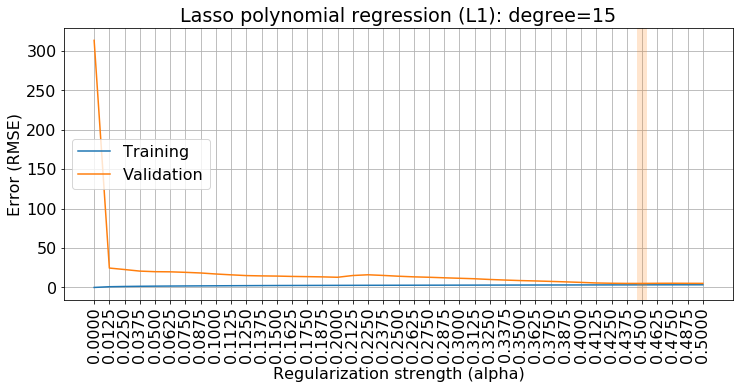

In [172]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=3,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

Оптимальный Альфа для нашей модели = 0,450

#### L2

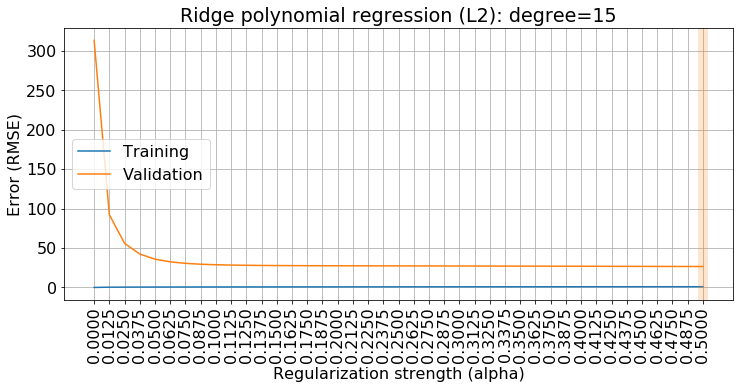

In [173]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=3,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

Оптимальный Альфа = 0,5. При L2-регуляризации, судя по всему ошибка никогда не равна 0.

#### Summary



Ну, в общем материал я усвоил конечно так себе, надо признать, формат подбешивает иногода и сам я не очень умен. Однако вещи интересные. По делу: Регуляризация - крутая штука. Кросс-валидация без сомнения тоже. Это все при условии, что задача ясна и можно использовать прекрасные библиотечные функции Sklearna, нюансов и тонкостей конечно уйма, но с опытом все придет. А третье задание я выполнил во втором, я уверен)